In [4]:
import pandas as pd

In [5]:
# Load the training data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Display the first few rows of the training data
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


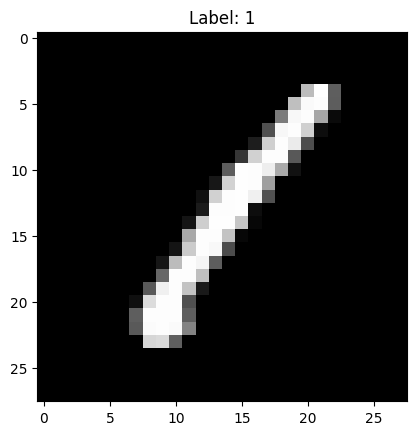

In [6]:
# visualize first sample
import matplotlib.pyplot as plt

first_image = train_data.iloc[0, 1:].values.reshape(28, 28)
plt.imshow(first_image, cmap='gray')
plt.title(f"Label: {train_data.iloc[0, 0]}")
plt.show()


In [10]:
# split data into features and labels
X_train = train_data.drop(columns=['label'])
y_train = train_data['label']

In [137]:
import torch

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

# traing and validation split
from sklearn.model_selection import train_test_split
X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = train_test_split(
    X_train_tensor, y_train_tensor, test_size=0.2, random_state=42
)

In [128]:
# TensorDataset and DataLoader
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [138]:
from torchvision import transforms

# Training transform with augmentation
train_transform = transforms.Compose([
    transforms.RandomAffine(
        degrees=15,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1),
        shear=10
    ),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Validation/test transform (no augmentation, just normalize)
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


In [139]:
# DigitDataset for training data augmentation
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class DigitDataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].numpy().reshape(28, 28).astype('uint8')
        image = Image.fromarray(image, mode='L')

        if self.transform:
            image = self.transform(image)

        if self.labels is not None:
            label = self.labels[idx]
            return image, label
        else:
            return image

In [140]:
train_dataset = DigitDataset(X_train_tensor, y_train_tensor, transform=train_transform)
val_dataset   = DigitDataset(X_val_tensor,   y_val_tensor,   transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=64, shuffle=False)

In [ ]:
# rotation by 10 degrees
# train_dataset = DigitDataset(
#     X_train_tensor, y_train_tensor,
#     transform=transforms.Compose([
#         transforms.RandomRotation(10),
#         transforms.ToTensor()
#     ])
# )

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [13]:
# normalize the data
X_train_tensor /= 255.0
X_train_tensor

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
class DigitRecognizerNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(28*28, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 10)
        self.relu = torch.nn.ReLU()
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.log_softmax(self.fc3(x))
        return x

In [134]:
import torch

class DigitRecognizerCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional Part
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)

        self.bn1 = torch.nn.BatchNorm2d(32)

        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        self.bn2 = torch.nn.BatchNorm2d(64)

        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        self.bn3 = torch.nn.BatchNorm2d(128)

        self.maxpool = torch.nn.MaxPool2d(kernel_size=2)
        
        # Classifier Part
        self.fc1 = torch.nn.Linear(128 * 3 * 3, 256)
        self.fc2 = torch.nn.Linear(256, 128)
        self.fc3 = torch.nn.Linear(128, 10)
        
        # Activation Functions
        self.relu = torch.nn.ReLU()
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

        # Dropout for regularization
        self.dropout = torch.nn.Dropout(p=0.3)

    def forward(self, x):
        # --- Feature Extraction ---
        # Reshape from flat to (batch, channels, height, width)
        x = x.view(-1, 1, 28, 28)
        
        # Pass through the first convolutional layer
        x = self.relu(self.bn1(self.conv1(x)))

        # Pass through the pooling layer
        x = self.maxpool(x)

        # Pass through the second convolutional layer
        x = self.relu(self.bn2(self.conv2(x)))
        
        # Pass through the pooling layer
        x = self.maxpool(x)

        # Pass through the third convolutional layer
        x = self.relu(self.bn3(self.conv3(x)))

        # Pass through the pooling layer
        x = self.maxpool(x)
        
        # --- Classification ---
        # Flatten the output for the fully connected layers
        x = x.view(-1, 128 * 3 * 3)
        
        # Pass through the fully connected layers
        x = self.relu(self.fc1(x))

        # Optional Dropout for regularization
        x = self.dropout(x)

        x = self.relu(self.fc2(x))

        # Optional Dropout for regularization
        x = self.dropout(x)
        
        x = self.log_softmax(self.fc3(x))
        
        return x

In [146]:
# loss function and optimizer
model = DigitRecognizerCNN()
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Add weight decay and learning rate scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # add weight decay
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

In [ ]:
# training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    # validation step
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

In [ ]:
best_val_loss = float("inf")
patience = 5
counter = 0

# training loop modified for DataLoader, using mini-batches
num_epochs = 30
for epoch in range(num_epochs):
    
    model.train() # Set the model to training mode

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # --- Validation Step ---
    model.eval() # Set the model to evaluation mode
    val_loss = 0
    correct = 0
    with torch.no_grad(): # Disable gradient calculation for validation
        for images, labels in val_loader:
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            
            # Get the predicted class
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")  # save best
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

    scheduler.step(val_loss)
    
    # Calculate average validation loss and accuracy
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / len(val_dataset)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

In [148]:
# load test data and preprocess
test_data_tensor = torch.tensor(test_data.values, dtype=torch.float32) / 255.0

In [149]:
# evaluate on test data
model.eval()
with torch.no_grad():
    test_outputs = model(test_data_tensor)
    _, predicted = torch.max(test_outputs, 1)

In [ ]:
import numpy as np

predictions_np = predicted.cpu().numpy()

print(predictions_np[:20])
print(np.unique(predictions_np, return_counts=True))

# submission dataframe
submission = pd.DataFrame({
    'ImageId': range(1, len(predictions_np) + 1),
    'Label': predictions_np
})
submission.to_csv('submission.csv', index=False)
submission.head()

In [ ]:
print(np.unique(predictions_np, return_counts=True))

In [157]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms

# same device as training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the SAME transforms as training (important!)
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # <-- only if you used this in training
])

# convert test data (N, 784) → (N, 1, 28, 28)
test_images = test_data.values.reshape(-1, 28, 28).astype("uint8")

# apply transforms in a custom Dataset
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if self.transform:
            img = self.transform(img)
        return img

test_dataset = TestDataset(test_images, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

# inference
model.eval()
all_preds = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        outputs = model(batch)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds.cpu())

predictions_np = torch.cat(all_preds).numpy()

# submission
submission = pd.DataFrame({
    "ImageId": range(1, len(predictions_np) + 1),
    "Label": predictions_np
})
submission.to_csv("submission.csv", index=False)


In [158]:
print(np.unique(predictions_np, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([2767, 3200, 2799, 2797, 2756, 2509, 2746, 2905, 2756, 2765]))


In [77]:
# evaluate on validation data
model.eval()
with torch.no_grad():
    val_outputs = model(X_val_tensor)
    _, val_predicted = torch.max(val_outputs, 1)
    val_accuracy = (val_predicted == y_val_tensor).float().mean()
    print(f'Validation Accuracy: {val_accuracy.item() * 100:.2f}%')

Validation Accuracy: 98.08%


In [78]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(y_val_tensor.numpy(), val_predicted.numpy()))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       816
           1       0.99      0.99      0.99       909
           2       0.99      0.98      0.98       846
           3       0.98      0.98      0.98       937
           4       0.98      0.99      0.98       839
           5       0.97      0.98      0.98       702
           6       0.98      0.98      0.98       785
           7       1.00      0.96      0.98       893
           8       0.98      0.97      0.97       835
           9       0.96      0.98      0.97       838

    accuracy                           0.98      8400
   macro avg       0.98      0.98      0.98      8400
weighted avg       0.98      0.98      0.98      8400



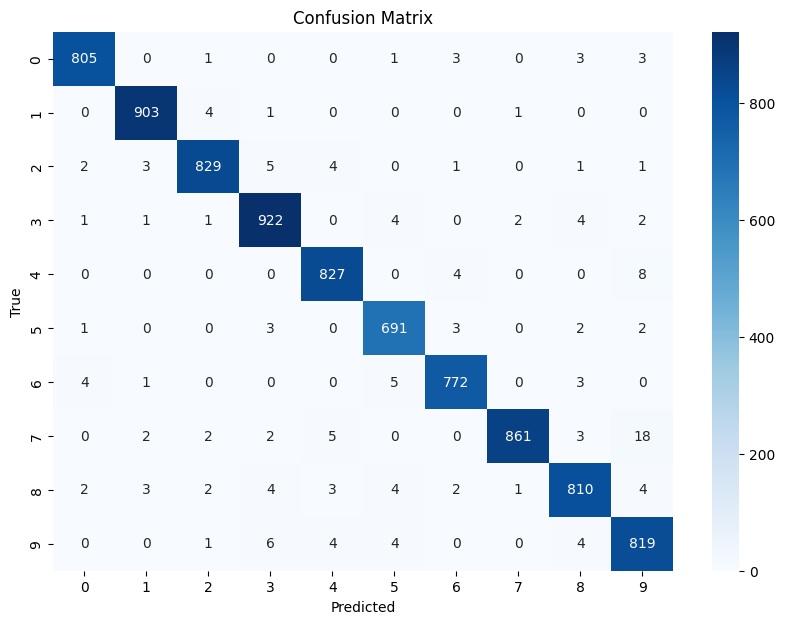

In [79]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_val_tensor.numpy(), val_predicted.numpy())
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()